<a href="https://colab.research.google.com/github/dscho15/deep-learning/blob/main/Lecture9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Articles

- https://medium.com/analytics-vidhya/spam-ham-classification-using-lstm-in-pytorch-950daec94a7c

- https://github.com/sijoonlee/spam-ham-walkthrough/blob/master/walkthrough.ipynb

- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html



# LSTM

In [3]:
import glob
from pathlib import Path
import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchtext.data import get_tokenizer
from tqdm.notebook import tqdm
from google_drive_downloader import GoogleDriveDownloader as gdd

torch.manual_seed(0)


# Example of how to use torch.gather

In [4]:
random_tensor = torch.randn(2, 3, 4)
pick_tensor = torch.tensor(
    [0, 1], dtype=torch.int64).unsqueeze(-1).repeat(1, 1, 4)
print(random_tensor)
val = torch.gather(random_tensor, 1, pick_tensor)
print(val)


tensor([[[-1.1258, -1.1524, -0.2506, -0.4339],
         [ 0.8487,  0.6920, -0.3160, -2.1152],
         [ 0.4681, -0.1577,  1.4437,  0.2660]],

        [[ 0.1665,  0.8744, -0.1435, -0.1116],
         [ 0.9318,  1.2590,  2.0050,  0.0537],
         [ 0.6181, -0.4128, -0.8411, -2.3160]]])
tensor([[[-1.1258, -1.1524, -0.2506, -0.4339],
         [ 0.8487,  0.6920, -0.3160, -2.1152]]])


In [5]:
# Download data

gdd.download_file_from_google_drive(
    '13DLnvpRhDO-D5JHCuPq85k_v-yMiMNCQ', '~/lingsmap_public-bare.zip', unzip=True)
assert Path('~/lingsmap_public-bare').exists()


  0%|          | 0/2893 [00:00<?, ?it/s]

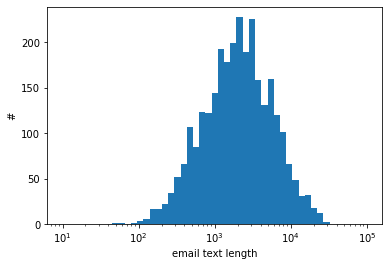

2893 emails
percentage spam: 0.17
ascii codes between 10 and 126


In [6]:
# Load data

filepaths = glob.glob('~/lingsmap_public-bare/*/*.txt')
emails = []
emails_ascii = []
targets = []

for i, filepath in enumerate(tqdm(filepaths)):
    with open(filepath) as file:
        email = file.read()
    emails.append(email)
    # convert character to ascii code
    emails_ascii.append([ord(c) for c in email])
    targets.append('spmsg' in filepath)

plt.hist([len(e) for e in emails], np.logspace(1, 5))
plt.xlabel('email text length')
plt.ylabel('#')
plt.xscale('log')
plt.show()

print(f'{len(emails)} emails')
print(f'percentage spam: {np.mean(targets):.2f}')
emails_ascii_flat = np.concatenate(emails_ascii)
print(
    f'ascii codes between {emails_ascii_flat.min()} and {emails_ascii_flat.max()}')


## So even if we just guess 'not spam' all the time, we can get 83 % correct. Lets consider this as the **baseline**.

In [172]:
# Preprocess emails
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
# nltk.download()

tokenizer = get_tokenizer("basic_english")
stop_words = stopwords.words('english')
for i in range(256):
    stop_words.append(chr(i))
for i in range(256):
    stop_words.append(chr(i)*2)


def clean_text(text):

    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)

    # remove punctuations and convert characters to lower case
    text_nopunct = "".join(
        [char.lower() for char in text_nonum if char not in string.punctuation])

    # substitute multiple whitespace with single whitespace, also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()

    return text_no_doublespace


def pre_process_words(email):
    global tokenizer

    text = clean_text(email)
    tokens = tokenizer(text)
    tokens = [word for word in tokens if not word in stop_words]

    return np.array(tokens)


def gen_vocab(emails):
    # take the mails and cat them
    email_cat = emails[0]

    for i in range(1, len(emails)):
        email_cat += " " + emails[i]

    # clean text from punctuations etc
    words = pre_process_words(email_cat)

    # get unique vocals
    return np.unique(words)

# examples:
# vocab = gen_vocab(emails)


In [188]:
class SpamEmailsDataset(torch.utils.data.Dataset):
    """Spam Email Dataset"""

    def __init__(self, emails, targets):

        # copy emails
        self.emails = np.array(emails.copy())

        # generate vocab
        vocab = np.append(gen_vocab(emails.copy()), ' ')
        self.vocab_dict = {ele: i for i, ele in enumerate(vocab)}

        # target spam / not spam
        self.targets = torch.tensor(targets).to(torch.float32)

        # used for the network
        self.lens = torch.empty_like(self.targets).to(torch.int32)

        # emails are in words
        emails_word_format = []
        for i in range(len(self.emails)):
            emails_word_format.append(
                pre_process_words(self.emails[i].copy()))

        # zero-pad the emails
        longest_len = 0
        for i in range(len(emails_word_format)):
            self.lens[i] = len(emails_word_format[i])
            if longest_len < self.lens[i]:
                longest_len = self.lens[i]

        # zero-pad the emails:
        for i in range(len(emails_word_format)):
            len_diff = longest_len - self.lens[i]
            emails_word_format[i] = list(emails_word_format[i])
            emails_word_format[i] += ' ' * len_diff

        self.indices_email = torch.zeros((len(emails_word_format), len(emails_word_format[0])), dtype=torch.long)
        for i, email_word_format in enumerate(emails_word_format):
            for j, word in enumerate(email_word_format):
                self.indices_email[i][j] = self.vocab_dict[word]

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, idx):
        return self.indices_email[idx], self.lens[idx], self.targets[idx]


# Spam Email Dataset # very slow
spam_email_dataset = SpamEmailsDataset(emails, targets)


In [6]:
# split training data up
(train_set, valid_set, test_set) = torch.utils.data.random_split(spam_email_dataset, [2000, 200, 693])

# dataloaders
batch_size = 32
loader_train = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=2)
loader_valid = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle=True, num_workers=2)
loader_test = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True, num_workers=2)

In [7]:
class SpamMailLSTM(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_size = 1, vocab_size = 117, embedding_dim = 10, drop_lstm=0.1, drop_out = 0.1):
        super().__init__()
        # Output size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_lstm, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(drop_out)
        
        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, seq_len):
        
        # sort the input and lengths as desecending order
        seq_len, perm_index = seq_len.sort(0, descending=True)
        x = x[perm_index]

        # embeddings
        embedded_seq_tensor = self.embedding(x)
                
        # pack, remove pads
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(embedded_seq_tensor, seq_len, batch_first=True)
        
        # lstm
        packed_output, _ = self.lstm(packed_input, None)

        # unpack, recover padded sequence 
        output_unpacked, seq_len_unpacked = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        seq_len_unpacked_d = (seq_len_unpacked - 1).to(device).unsqueeze(-1).repeat(1, 1, self.hidden_dim)
        output_unpacked = torch.gather(output_unpacked, 1, seq_len_unpacked_d).squeeze(0)

        # dropout and fully-connected layer
        output_unpacked = self.dropout(output_unpacked)
        output_unpacked = self.fc(output_unpacked).squeeze()
               
        # sigmoid function
        logits = self.sig(output_unpacked)
        
        return logits, perm_index

In [8]:
# Hyperparameters:
SETTINGS = {"batch_size": batch_size,
            "embedding_dim": 10,
            "n_layers": 2,
            "hidden_dim": 64,
            "epoch": 20,
            "lr": 2e-5,
            "clip": 5}

device = torch.device("cuda")

In [9]:
spam_lstm_net = SpamMailLSTM( hidden_dim = SETTINGS["hidden_dim"], \
                              n_layers = SETTINGS["n_layers"], \
                              output_size = 1, \
                              vocab_size = 117, \
                              embedding_dim = SETTINGS["embedding_dim"] \
                             ).to(device)

opt = torch.optim.Adam(spam_lstm_net.parameters(), SETTINGS["lr"])
criterion = torch.nn.BCELoss()

train_loss, valid_loss = [], []
train_accuracy, valid_accuracy = [], []

for epoch in tqdm(range(SETTINGS["epoch"])):

  # Set to training mode
  spam_lstm_net.train()

  # Parameters
  losses, accuracy = [], []

  for x, seq_len, y in loader_train:
    
    # Get data pairs (input, target)
    x, y = x.to(device), y.to(device)

    # Returns the logits
    logits, perm_index = spam_lstm_net(x, seq_len)

    # Compute the loss
    loss = criterion(logits, y[perm_index])
    opt.zero_grad()
    loss.backward()

    # Step
    nn.utils.clip_grad_norm_(spam_lstm_net.parameters(), SETTINGS["clip"])
    opt.step()

    accuracy.append((torch.sum((logits > 0.5).to(torch.float32) == y[perm_index])).detach().cpu().item())
    losses.append(loss.item())
  
  # Update loss
  train_loss.append(np.mean(losses))
  train_accuracy.append(np.mean(accuracy)/2000)

  # Set to eval mode
  spam_lstm_net.eval()

  with torch.no_grad():

    # Parameters
    losses, accuracy = [], []

    for x, seq_len, y in loader_valid:
      
      # Get data pairs (input, target)
      x, y = x.to(device), y.to(device)

      # Returns the logits
      logits, perm_index = spam_lstm_net(x, seq_len)

      # Compute the loss
      loss = criterion(logits, y[perm_index])
      
      accuracy.append((torch.sum((logits > 0.5).to(torch.float32) == y[perm_index])).detach().cpu().item())
      losses.append(loss.item())
  
  # Update loss
  valid_loss.append(np.mean(losses))
  valid_accuracy.append(np.mean(accuracy)/200)
  
plt.figure(1)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.figure(2)
plt.plot(valid_accuracy)
plt.plot(train_accuracy)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

AttributeError: module 'matplotlib.pyplot' has no attribute 'plt'

<Figure size 432x288 with 0 Axes>

In [11]:
spam_lstm_net.eval()

with torch.no_grad():

    # Parameters
    losses, accuracy = [], []

    for x, seq_len, y in loader_test:
        
        # Get data pairs (input, target)
        x, y = x.to(device), y.to(device)

        # Returns the logits
        logits, perm_index = spam_lstm_net(x, seq_len)
        
        print(logits, y[perm_index])
        
        # Accuracy
        accuracy.append((torch.sum((logits > 0.5).to(torch.float32) == y[perm_index])).detach().cpu().item())

# Update loss
test_accuracy = (np.mean(accuracy)/693)

print(test_accuracy)

tensor([0.1721, 0.1645, 0.1775, 0.1534, 0.1628, 0.1787, 0.1640, 0.1611, 0.1579,
        0.1685, 0.1696, 0.1551, 0.1691, 0.1542, 0.1673, 0.1687, 0.1433, 0.1472,
        0.2152, 0.1529, 0.1498, 0.1551, 0.1770, 0.1842, 0.1700, 0.1633, 0.1485,
        0.1599, 0.1461, 0.1649, 0.1732, 0.1460], device='cuda:0') tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.1595, 0.1467, 0.1593, 0.1722, 0.1702, 0.1837, 0.1680, 0.1571, 0.1822,
        0.1588, 0.1622, 0.1699, 0.1696, 0.1533, 0.1627, 0.1650, 0.1815, 0.1673,
        0.1626, 0.1652, 0.1620, 0.1699, 0.1598, 0.1553, 0.1659, 0.1639, 0.1804,
        0.1579, 0.1529, 0.1788, 0.1568, 0.1530], device='cuda:0') tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')
tensor([0.1834, 0.1621, 0.1549, 0.1688, 0.1643, 0.

# Bonus - Number sorting
Create and train a NN to sort a sequence of iid standard normally distributed numbers  
Hint: Encoder-Decoder